In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from time import gmtime, strftime

import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.13.0-rc2
2.2.4-tf


#### 1) Custom DNN regressor with estimator
#### 2) CNN sequential Keras API
#### 3) CNN functional Keras API

# 2) Data Processing

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
def preprocess_data(df_train):
    df_train_rand = df_train.reindex(np.random.permutation(df_train.index))
    return df_train_rand

In [10]:
def preprocess_features(x_train):
    #Normalization to greyscale, reduces the effect of illumination's differences
    x_train_norm = x_train / 255.0
    #Reshaping for keras 28x28x1 3D matrices?
    x_train_norm = x_train_norm.values.reshape(-1, 28, 28, 1)
    return x_train_norm

In [15]:
def preprocess_targets(y_train):
    #Encode labels to one hot vecs
    y_train_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
    return y_train_hot

In [16]:
df_train_rand = preprocess_data(df_train)
X_train = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).head(38000).copy())
X_val = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).tail(6000).copy())
Y_train = preprocess_targets(df_train_rand['label'].head(38000).copy())
Y_val = preprocess_targets(df_train_rand['label'].tail(6000).copy())

In [42]:
X_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

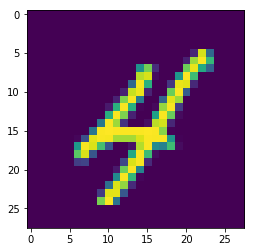

In [43]:
g = plt.imshow(X_train[0][:,:,0])

Filters are transformations of the image.
Filters' size is defined by kernel size


In [18]:
#Architecture:
#[[Conv2D->reulu]*2] -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Softmax
 
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28, 28, 1)))
#The model needs to know what input shape it should expect, the following layer can do automatic shape inference
# by counting the previous layers output shape? yes, we already have that number
# 2D layers such as dense support input_dim instead of input_shape
model.add(layers.Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu'))

model.add(layers.MaxPool2D(pool_size=(2,2),
                   strides=(2,2)))
# it is typical to not have overlap during pooling, I intuit it is in order to reduce noise and duplication

model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))
model.add(layers.Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))

model.add(layers.MaxPool2D(pool_size=(2,2),
                    strides=(2,2)))


model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(245, activation = 'relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = 'softmax'))

In [19]:
# Optimizer, required for compiling a Keras model
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001,
                                   beta1 = 0.9,
                                   beta2 = 0.999,
                                   epsilon = 1e-08,
                                   use_locking = False,
                                  name = 'Adam')

In [20]:
# optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

In [21]:
# Compiling
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
# Learning rate reduction
# Keras has a list of callback functions which we can use to apply at different stages of training.
# We can pass the as the keyword argument 'callbacks' to the .fit() method of Sequential or Model classes
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
# the learning rate is reduced.
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factore = 0.5,
                                           min_lr = 0.00001)

In [35]:
epochs = 2
batch_size = 80

In [36]:
# Data augmentation


In [37]:
# Fit, returns a History object, its history attribute is a record of training loss values and metrics values at 
# sequential epochs, as well as validation loss values and validation metrics values
history = model.fit(X_train,
                    Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_val, Y_val),
                    verbose = 2)

Train on 38000 samples, validate on 6000 samples
Epoch 1/2
 - 170s - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0358 - val_acc: 0.9917
Epoch 2/2
 - 154s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0291 - val_acc: 0.9937


In [1]:
predictions = model.predict(df_test)

NameError: name 'model' is not defined